# EC_LightningStorms Speedboat: Overview & Tasks

In [ ]:
import xarray as xr
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
import matplotlib.pyplot as plt
import geopandas as gpd

### TASK 1: Finding storm positions & creating a storm catalog
- Identify storm positions (peaks in lightning activity) alongtrack EarthCARE satellite

- Create a storm catalog with storm positions and their characteristics

- Try different methods to identify storm positions and different settings for the lightning data 
    - lightning groups vs. unique flashes
    - different time windows
    - different radius around each EarthCARE track point

- Think about what storm metadata/characteristics can be added to the storm catalog? e.g. datetime, groups vs. flashes characetristics

How lightning data looks like?

<img src="lightning_msi.png" alt="How lightning data looks like?" width="400">

In [4]:
# Example processed lightning data
lgr_path_proc = '/home/bpiskala/Object_Data/LI/20250209/LI_LGR_20250209T053242Z_20250209T063403Z_995_33_03988A.nc'
lgr_proc = xr.open_dataset(lgr_path_proc, decode_timedelta=True)
lgr_proc

<xarray.Dataset> Size: 267kB
Dimensions:                       (groups: 995, auxiliary_dataset: 1)
Dimensions without coordinates: groups, auxiliary_dataset
Data variables: (12/17)
    auxiliary_dataset_identifier  (groups, auxiliary_dataset) <U44 175kB ...
    auxiliary_dataset_status      (groups, auxiliary_dataset) float32 4kB ...
    l1b_missing_warning           (groups) float32 4kB ...
    l1b_geolocation_warning       (groups) float32 4kB ...
    l1b_radiometric_warning       (groups) float32 4kB ...
    group_time                    (groups) datetime64[ns] 8kB ...
    ...                            ...
    number_of_events              (groups) float32 4kB ...
    group_filter_qa               (groups) float32 4kB ...
    parallax_corrected_lat        (groups) float64 8kB ...
    parallax_corrected_lon        (groups) float64 8kB ...
    ec_time_diff                  (groups) timedelta64[ns] 8kB ...
    distance_from_nadir           (groups) float64 8kB ...
Attributes: (12/65)
    title:                                
    summary:                              
    keywords:                             
    keywords_vocabulary:                  
    subtype:                              
    component1:                           
    ...                                   ...
    count_in_repeat_cycle:                0001
    processed_count_in_repeat_cycle:      0001
    environment:                          OPE
    type:                                 LGR
    product_id:                           LI-2-LGR-x-FD
    disposition_mode:                     O

#### How to get lightning information around EarthCARE CPR track points?
Here we get data lightning data within ± 150 seconds and ± 2.5 km around each EarthCARE track point.

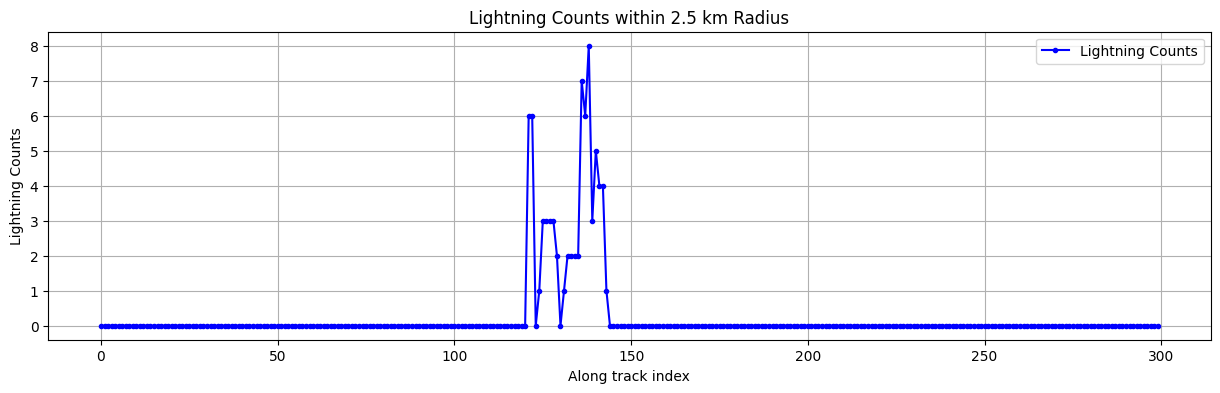

In [8]:
# Convert time differences to seconds
time_diff_seconds = lgr_proc.ec_time_diff.values.astype('timedelta64[s]')

# Set filter value for valid time differences (in seconds)
time_filter = 150

# Identify valid indices where the time difference is within the filter range
valid_indices = (time_diff_seconds >= -time_filter) & (time_diff_seconds <= time_filter)

# Extract valid latitude and longitude values from the lgr dataset
valid_latitudes = lgr_proc.parallax_corrected_lat.values[valid_indices]
valid_longitudes = lgr_proc.parallax_corrected_lon.values[valid_indices]

# Function to convert latitudes and longitudes to radians
def to_radians(degrees):
    return np.radians(degrees)

# Open the CPR dataset
cpr_dataset_path = '/home/bpiskala/Object_Data/EarthCARE/h5/20250209/CPR_FMR_2A/ECA_EXAB_CPR_FMR_2A_20250209T055812Z_20250209T082708Z_03988A.h5'
cpr_data = xr.open_dataset(cpr_dataset_path, group='ScienceData', engine='netcdf4')

# Convert CPR dataset latitude and longitude to radians
cpr_lat_rad, cpr_lon_rad = to_radians(cpr_data.latitude.values), to_radians(cpr_data.longitude.values)

# Convert the valid latitudes and longitudes from the lgr dataset to radians
lgr_lat_rad, lgr_lon_rad = to_radians(valid_latitudes), to_radians(valid_longitudes)

# Stack the latitude and longitude values into 2D arrays for distance calculations
cpr_coords_rad = np.vstack((cpr_lat_rad, cpr_lon_rad)).T
lgr_coords_rad = np.vstack((lgr_lat_rad, lgr_lon_rad)).T

# Calculate all pairwise haversine distances
# The haversine distance function returns distances in radians; multiply by Earth's radius to convert to kilometers
earth_radius_km = 6371
distance_matrix_km = haversine_distances(cpr_coords_rad, lgr_coords_rad) * earth_radius_km

# Define the radius within which lightning points are considered close (in km)
radius_km = 2.5

# Count the number of lightning points within the specified radius for each CPR point
lightning_counts = np.sum(distance_matrix_km <= radius_km, axis=1)

# Plot the lightning counts for a specific range of the data
plt.figure(figsize=(15, 4))
plt.plot(np.arange(len(lightning_counts[700:1000])), lightning_counts[700:1000], marker='.', linestyle='-', color='b', label='Lightning Counts')

# Adding labels, title, and grid
plt.xlabel('Along track index')
plt.ylabel('Lightning Counts')
plt.title('Lightning Counts within 2.5 km Radius')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Example storm catalog
file_path = "/home/bpiskala/repositories/EC-StormTracker/sample_storm_catalog.geojson"
gdf = gpd.read_file(file_path)
gdf

,ID,EarthCARE_Frame,Latitude,Longitude,Peak_Lightning_Count,Dataset,geometry
0,1,04023E,-8.258811,15.728007,95,LI,POINT (15.72801 -8.25881)
1,2,03999H,-25.544843,25.940853,4,LI,POINT (25.94085 -25.54484)
2,3,03999H,-25.407039,25.911326,7,LI,POINT (25.91133 -25.40704)
3,4,03988A,-15.054621,-58.555357,6,LI,POINT (-58.55536 -15.05462)
4,5,03988A,-14.896281,-58.586335,8,LI,POINT (-58.58633 -14.89628)
5,6,03988A,2.299142,-61.834643,6,LI,POINT (-61.83464 2.29914)


### TASK 2: Visualization tool development
- Build a Python visualization tool to visualize the storm catalog

- Suggested scripts structure:  
scripts/  
├── visualize_storms.py  
├── config.py  # Color scales, etc.  
└── utils.py   # Helper functions (lat/lon calculations)  

- Load storm catalog & filter based on:
    - EarthCARE frame
    - time
    - geographic position
    - lightning threshold
    - etc.

- Find relevant EarthCARE data based on the frames and display products in a calculated range of latitudes:
    - scatter plot for lightning (2D or 1D)
    - vertical profiles of EarthCARE data
    - horizontal MSI images
    - position on globe



- Output: a Jupyter notebook with examples of how to visualize storms

- Later play with settings of display (decide for each product displayed):
    - establish color scales
    - log-linear scales for vertical profiles
    - ticks & labels

- Think about how large area around storm should be displayed

- Which products to start with? (e.g. could be useful for the TASK 1)

- Think about different modes for displaying data, e.g.:
    - single storm quicklook with multiple products
    - storms comparison with multiple products (e.g. one storm per row)
    - single product comparison with multiple storms

- Inspiration: [ectools](https://bitbucket.org/smason/ectools/src/main/)

### TASK 3: Storm cell tracking
- Define storm tracking method using 2D lighnting data: 
    - Use lightning clusters to create polygons every 2, 5, x? minutes
    - Connect the polygons to track the storm cells

- Output: polygons for storm cells in different time steps assigned to each storm in the storm catalog + connected paths of moving storms --> both can be added as additional geometry to the storm catalog

- Is it better to use lightning groups or unique flashes for tracking cells?

- Is ± 30 min around the EarthCARE overpass enough for tracking development of storms?

- Storms may split or merge, how to handle this?

- How can we then characterize the stage of storm development? e.g. mature, decaying, etc. according to lightning activity in the subsequent storm cells